# Simple demo for table reconstruction


## Import packages

In [1]:
import cv2
import torch
import numpy as np

## Import packages used for visualizing

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# Support functions

In [3]:
def visualize_lines(vis_mask, coords):
    for coor in coords:
        x1, y1, x2, y2 = coor
        cv2.line(vis_mask, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return vis_mask


def visualize_cells(vis_mask, coords):
    for coor in coords:
        x1, x2, y1, y2 = coor
        vis_mask = cv2.rectangle(vis_mask, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return vis_mask


def visualize_point(vis_mask, coords):
    for coor in coords:
        x, y = coor
        x = int(x)
        y = int(y)
        vis_mask = cv2.circle(vis_mask, (x, y), 5, (255, 255, 255), 2)

    return vis_mask


## Force CPU

In [4]:
torch.cuda.is_available = lambda: False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare image

## Read sample image

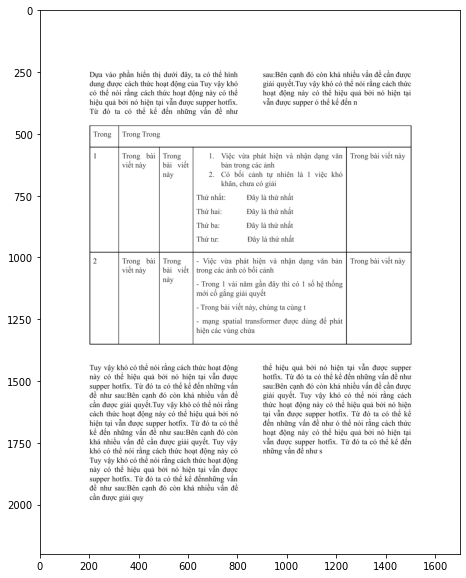

In [5]:
image = cv2.imread("table.png")

plt.imshow(image)

# TL:DR

In [6]:
from table_reconstruction import TableExtraction

In [7]:
extraction = TableExtraction(device=device)

Downloading...
From: https://drive.google.com/uc?id=12ttln8zPOWrFCPLr4hChmxr4rxuHRRoz
To: /home/niits/SUN/table_reconstruction/table_reconstruction/table_detection/tmp/model_table_detect.pt
3.56MB [00:00, 7.19MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=18YEiAzUs9NXz0FwBuU0JicEWc_F2V7tq
To: /home/niits/SUN/table_reconstruction/table_reconstruction/line_segmentation/tmp/resnet_weight.pth
25.7MB [00:03, 7.44MB/s]


In [8]:
tables = extraction.extract(image)

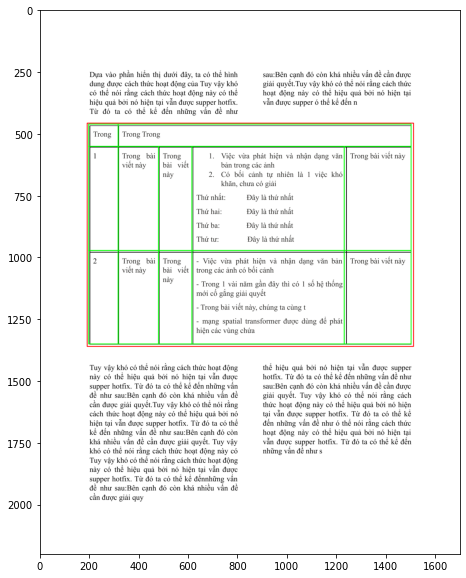

In [9]:
visualization = image.copy()
for table in tables:
    t_x_min, t_x_max, t_y_min, t_y_max = table.coordinate
    cv2.rectangle(
        visualization,
        (t_x_min, t_y_min),
        (t_x_max, t_y_max),
        (255, 0, 0),
        thickness=2,
        lineType=cv2.LINE_AA,
    )
    for cell in table.cells:
        x_min, x_max, y_min, y_max = cell.coordinate
        cv2.rectangle(
            visualization,
            (x_min + t_x_min, y_min + t_y_min),
            (x_max + t_x_min, y_max + t_y_min),
            (0, 255, 0),
            thickness=2,
            lineType=cv2.LINE_AA,
        )

plt.imshow(visualization)

# Reconstruct table

## Detect table region

In [10]:
from table_reconstruction.table_detection.detector import TableDetector

In [11]:
table_detector = TableDetector(device=device)

In [12]:
table_regions = table_detector.predict([image])

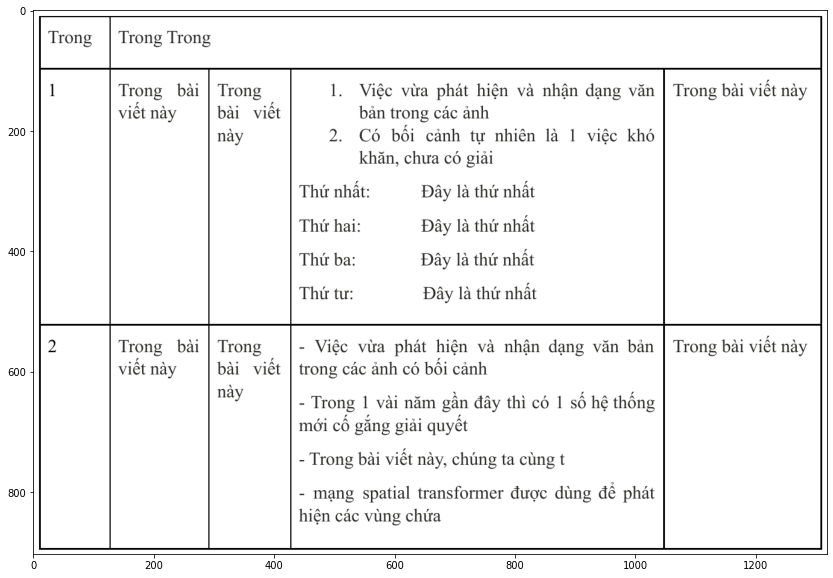

In [13]:
x_min, y_min, x_max, y_max = table_regions[0][0]

img = image[y_min:y_max, x_min:x_max]
plt.imshow(img)

## Segment lines

In [14]:
from table_reconstruction.line_segmentation.line_segment import LineSegmentation

In [15]:
h, w, _ = img.shape
padding_img = np.ones((h + 10, w + 10, 3), dtype=np.uint8) * 255
padding_img[5 : h + 5, 5 : w + 5, :] = img

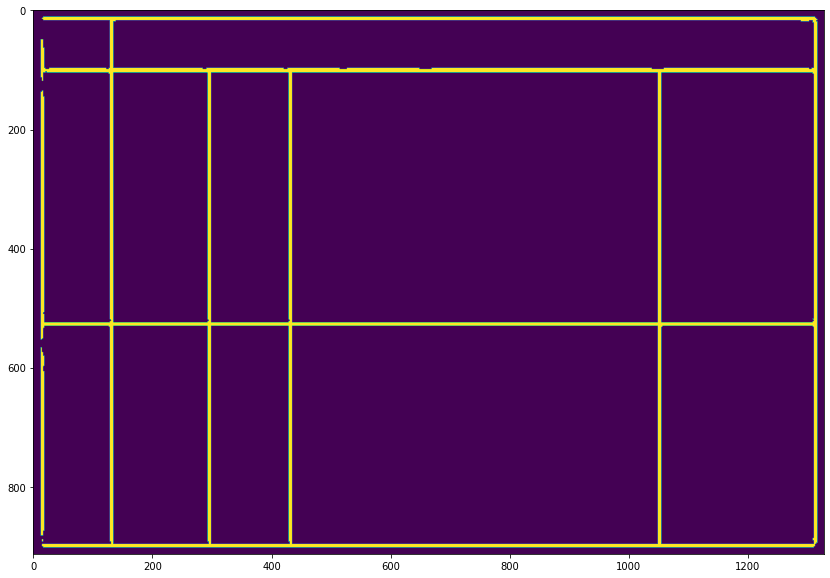

In [16]:
line_segmentation = LineSegmentation(device=device)
mask = line_segmentation.predict(padding_img)
plt.imshow(mask)

# Predict lines and reconstruct grid

In [17]:
from table_reconstruction.utils.cell_utils import (
    calculate_cell_coordinate,
    get_intersection_points,
    predict_relation,
    sort_cell,
)
from table_reconstruction.utils.lines_utils import get_coordinates
from table_reconstruction.utils.mask_utils import normalize
from table_reconstruction.utils.table_utils import (
    DirectedGraph,
    convertSpanCell2DocxCoord,
)

## Nomalize segmented mask

In [18]:
mask = normalize(img, mask_img=mask)
mask = np.array(mask[5 : h + 5, 5 : w + 5])

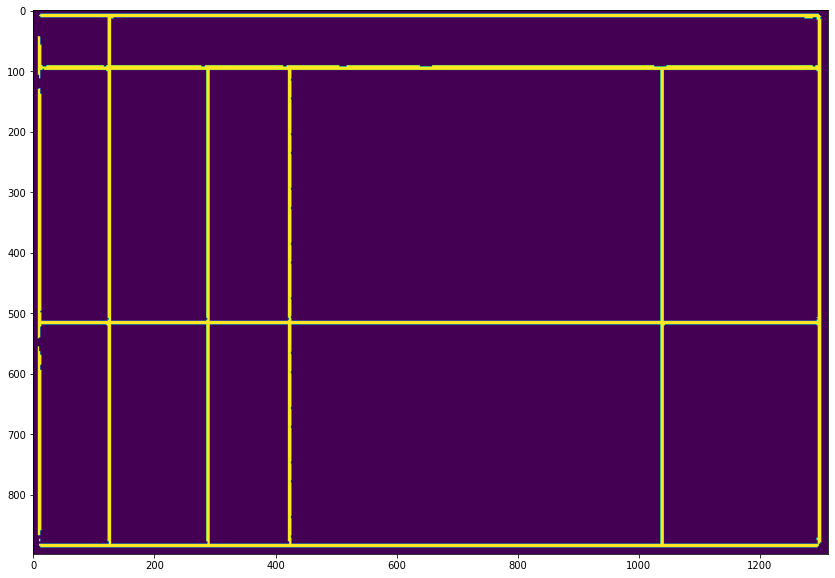

In [18]:
plt.imshow(mask)

## Get intersection points in this table

In [19]:
normalize_thresh = 15
tab_coord, vertical_lines_coord, horizontal_lines_coord = get_coordinates(
    mask, ths=normalize_thresh
)



### Detect straight lines

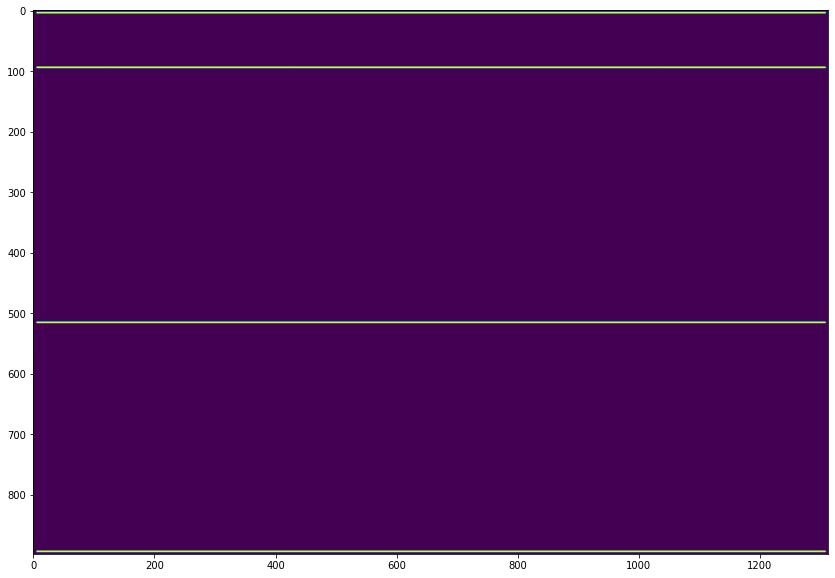

In [20]:
vis_mask = mask.copy()
visualize_lines(vis_mask, horizontal_lines_coord)
plt.imshow(vis_mask)

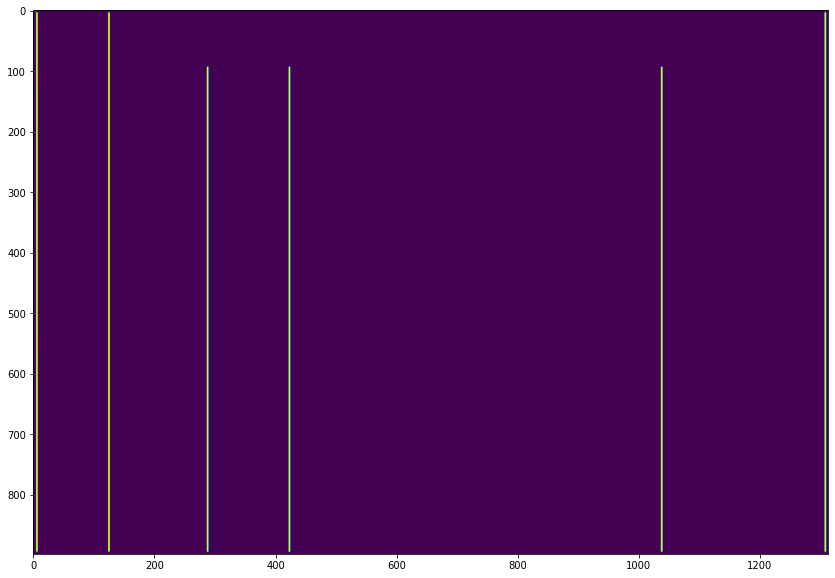

In [21]:
vis_mask = mask.copy()
visualize_lines(vis_mask, vertical_lines_coord)
plt.imshow(vis_mask)

### Get intersect points

In [23]:

intersect_points, fake_intersect_points = get_intersection_points(
    horizontal_lines_coord, vertical_lines_coord, tab_coord
)


898 1313


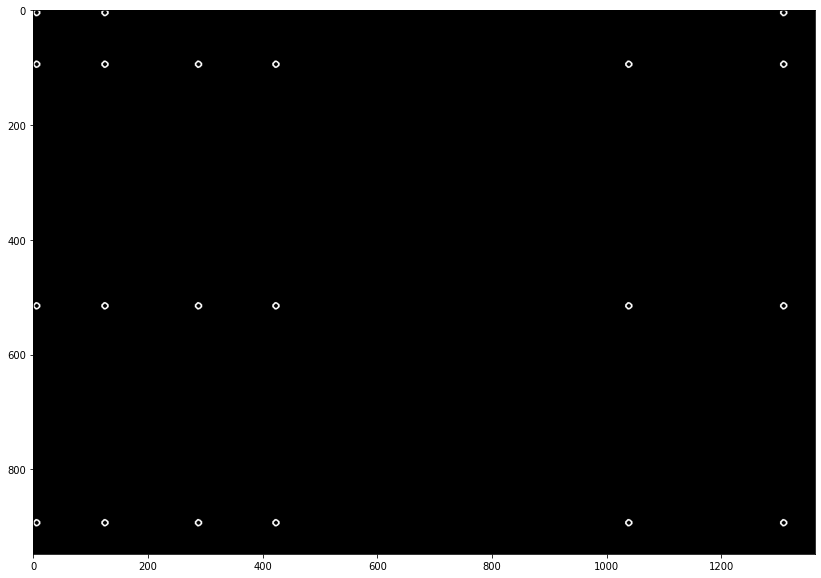

In [24]:
h, w = mask.shape
print(h, w)
vis_mask = np.zeros((h + 50, w + 50, 3))
vis_mask = visualize_point(vis_mask, intersect_points.copy())
plt.imshow(vis_mask)

## Detect table cells

In [25]:

cells = calculate_cell_coordinate(
    intersect_points.copy(),
    False,
    normalize_thresh,
    [horizontal_lines_coord, vertical_lines_coord],
)

fake_cells = calculate_cell_coordinate(
    fake_intersect_points.copy(), True, normalize_thresh
)


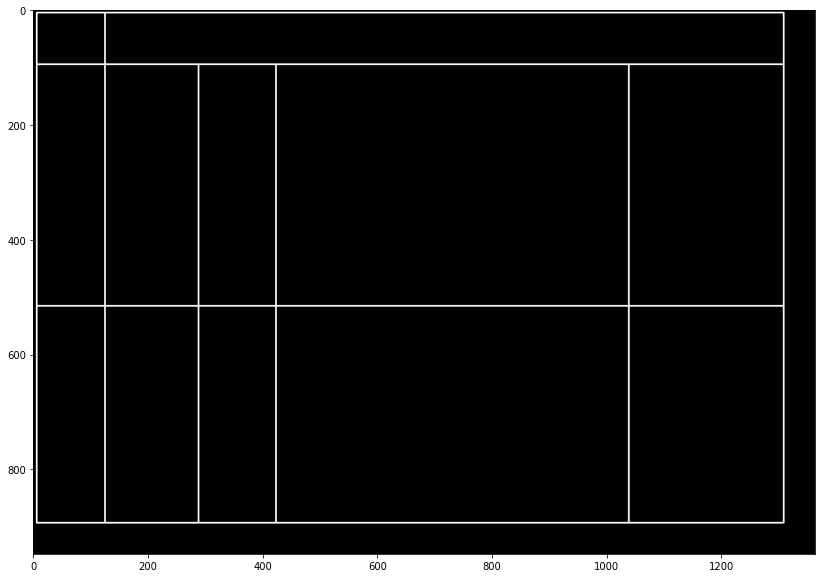

In [26]:
h, w = mask.shape
vis_mask = np.zeros((h + 50, w + 50, 3))
vis_mask = visualize_cells(vis_mask, cells.copy())
plt.imshow(vis_mask)

## Sort cells and predict relation

In [28]:
cells = sort_cell(cells=np.array(cells))
fake_cells = sort_cell(cells=np.array(fake_cells))

hor_couple_ids, ver_couple_ids = predict_relation(cells)

H_Graph = DirectedGraph(len(cells))
H_Graph.add_edges(hor_couple_ids)
nb_col = H_Graph.findLongestPath()
V_Graph = DirectedGraph(len(cells))
V_Graph.add_edges(ver_couple_ids)
nb_row = V_Graph.findLongestPath()

span_list = convertSpanCell2DocxCoord(
    cells, fake_cells, list(range(len(cells))), nb_col
)

In [38]:
print("Number of colums: {}".format(nb_col))
print("Number of rows: {}".format(nb_row))

for coord, span in zip(cells, span_list):
    print(
        "cell belongs to column {} row {}, spans {} unit by column and {} units by row with coordinates {}".format(
            span["x"][0], span["y"][0], span["x"][1], span["y"][1], coord
        )
    )


Number of colums: 5
Number of rows: 3
cell belongs to column 0 row 0, spans 0 unit by column and 0 units by row with coordinates [6, 125, 4, 94]
cell belongs to column 1 row 0, spans 4 unit by column and 0 units by row with coordinates [125, 1308, 4, 94]
cell belongs to column 0 row 1, spans 0 unit by column and 1 units by row with coordinates [6, 125, 94, 515]
cell belongs to column 1 row 1, spans 1 unit by column and 1 units by row with coordinates [125, 288, 94, 515]
cell belongs to column 2 row 1, spans 2 unit by column and 1 units by row with coordinates [288, 423, 94, 515]
cell belongs to column 3 row 1, spans 3 unit by column and 1 units by row with coordinates [423, 1038, 94, 515]
cell belongs to column 4 row 1, spans 4 unit by column and 1 units by row with coordinates [1038, 1308, 94, 515]
cell belongs to column 0 row 2, spans 0 unit by column and 2 units by row with coordinates [6, 125, 515, 893]
cell belongs to column 1 row 2, spans 1 unit by column and 2 units by row with 